In [1]:
import os
import torchvision

from torch import cuda, device, Tensor, save, load, stack, zeros, vstack
from src.plots import plot_vae_training_result, plot_image, plot_image_label_two
from src.vae.mnist_vae import ConditionalVae
from src.image_classifier.image_classifier import MNISTClassifier
from src.utils import frechet_inception_distance
from src.sampling import split_dirichlet

device = device('cuda' if cuda.is_available() else 'cpu')

In [2]:
num_data = 60000

training_data = torchvision.datasets.MNIST(root='../../data/MNIST_train', train=True, download=True, transform=torchvision.transforms.ToTensor())
testing_data = torchvision.datasets.MNIST(root='../../data/MNIST_test', train=False, download=True, transform=torchvision.transforms.ToTensor())

input = training_data.data[:num_data] / 255.0    # convert to float
labels = training_data.targets[:num_data]

# # non-IID setting
# dirichlet_beta = 1.0
# num_users = 1
# 
# # only considers distribution-based label imbalance (quantity is shown to have least impact. Feature imbalanace is out of this research scope)
# users_data = split_dirichlet(dataset=training_data, num_users=10, is_cfar=False, beta=dirichlet_beta)
# 
# total_input = []
# total_labels = []
# total_counts = []
# for user_idx in users_data:
#     images = []
#     outputs = []
#     counts = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
# 
#     for data_idx in users_data[user_idx]:
#         image = input[int(data_idx)]
#         images.append(image)
#         label = labels[int(data_idx)]
#         outputs.append(label)
#         counts[label] +=1
#     print(counts)
#     print(sum(counts))
#     total_input.append(images)
#     total_labels.append(outputs)
#     total_counts.append(counts)
# 
# user_idx = 0
# sample_input = total_input[user_idx]
# sample_label = total_labels[user_idx]
# 
# input_tensor = stack(sample_input)
# label_tensor = stack(sample_label)
# 
# plot_image_label_two(input_tensor.cpu().detach().numpy(), label_tensor.cpu().detach().numpy())
# 
# assert input_tensor.shape[0] == label_tensor.shape[0]
# 
# training_data.data = input_tensor
# training_data.targets = label_tensor

In [3]:
# parameters
model = "cvae"
dataset = "mnist"
batch_size = 64
epoch = 10
learning_rate = 0.01

model_path = f"../../models/{model}_{dataset}_{batch_size}_{epoch}_{learning_rate}.pt"

if os.path.exists(model_path):
    vae = load(model_path)
else:
    vae = ConditionalVae(dim_encoding=3).to(device)

    # try with model sigma
    vae_model, vae_loss_li, kl_loss_li = vae.train_model(
        training_data=training_data,
        batch_size=batch_size,
        epochs=epoch,
        learning_rate=learning_rate
    )
    save(vae, model_path)
    
    # move tensors to cpu before converting to np array
    np_kl_loss_li = []
    
    for output in kl_loss_li:
        if isinstance(output, Tensor):
            np_kl_loss_li.append(output.cpu().detach().numpy())
    
    # plot results
    plot_vae_training_result(
        input=input,
        labels=labels,
        vae_model=vae_model,
        vae_loss_li=vae_loss_li,
        kl_loss_li=np_kl_loss_li
    )

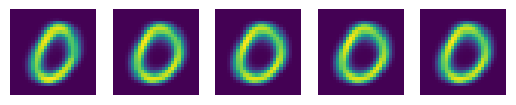

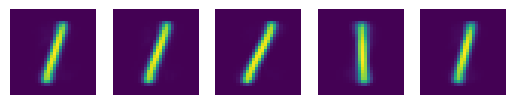

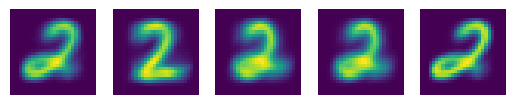

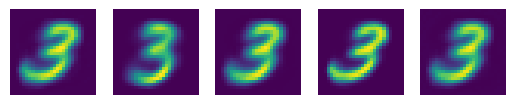

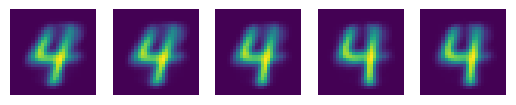

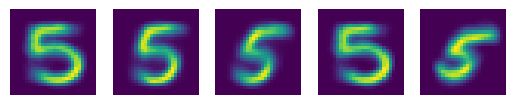

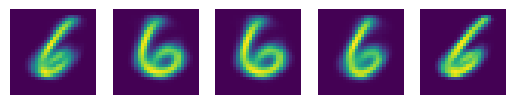

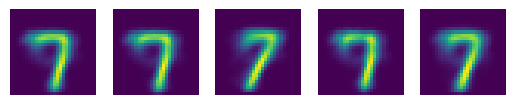

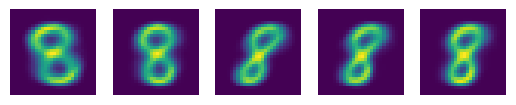

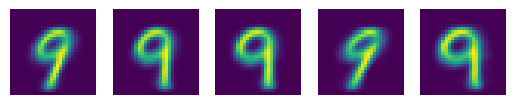

In [4]:
for i in range(10):
    images = vae.generate_data(n_samples=5, target_label=i)
    plot_image(images)

In [5]:
# train classifier for performance evaluation
model = "classifier"
dataset = "mnist"
batch_size = 64
epoch = 10

classifier_path = f"../../models/{model}_{dataset}_{batch_size}_{epoch}.pt"

if os.path.exists(classifier_path):
    classifier = load(classifier_path)
else:
    classifier = MNISTClassifier(input_size=784, num_classes=10)
    classifier.train_model(training_data, batch_size=batch_size, epochs=epoch)
accuracy = classifier.test_model(testing_data)
print("Test accuracy: ", accuracy)
save(classifier, classifier_path)

Epoch done:  1
Epoch done:  2
Epoch done:  3
Epoch done:  4
Epoch done:  5
Epoch done:  6
Epoch done:  7
Epoch done:  8
Epoch done:  9
Epoch done:  10
Test accuracy:  0.9804


In [6]:
# generate data for testing on classifier
# this one stays the same
data_count = 10000
ratios = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
images = []
labels = []

for label_idx, ratio in enumerate(ratios):
    num_samples_to_generate = int(data_count * ratio)
    images.append(vae.generate_data(n_samples=num_samples_to_generate, target_label=label_idx).cpu().detach())
    
    label = zeros((num_samples_to_generate, 10), device=device)
    label[:, label_idx] = 1
    labels.append(label.cpu().detach())

final_images = vstack(images)
final_labels = vstack(labels)

assert final_images.shape[0] == final_labels.shape[0]

accuracy = classifier.test_model_syn_img_label(final_images, final_labels)
print("Accuracy: ", accuracy)

Accuracy:  0.9993


In [6]:
# Determine FID
# generate 500 images
# normalizing necessary to make pixels in [0, 1] range for FID

testing_data = torchvision.datasets.MNIST(root='../../data/MNIST_test', train=False, download=True, transform=torchvision.transforms.ToTensor())

num_data = 400

input = testing_data.data[:num_data] / 255.0
syn_input = vae.generate_data(n_samples=num_data)

input_rgb = input.view(-1, 1, 28, 28).repeat(1, 3, 1, 1)
syn_input_rgb = syn_input.view(-1, 1, 28, 28).repeat(1, 3, 1, 1)

# compute FID score
fid_score = frechet_inception_distance(input_rgb, syn_input_rgb)
print("Frechet Inception Distance: ", fid_score)

NameError: name 'vae' is not defined

In [9]:
# test baseline as IID data
num_users = [3, 5, 10]
for num_user in num_users:
    model_state_dict_path = f"../../models/federated_cvae_mnist_1_1.0_20_2_{num_user}.pt"
    loaded_state_dict = load(model_state_dict_path)
    global_model = ConditionalVae(dim_encoding=3)
    global_model.load_state_dict(loaded_state_dict)
        
    data_count = 10000
    ratios = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
    images = []
    labels = []
    
    for label_idx, ratio in enumerate(ratios):
        num_samples_to_generate = int(data_count * ratio)
        images.append(global_model.generate_data(n_samples=num_samples_to_generate, target_label=label_idx).cpu().detach())
        
        label = zeros((num_samples_to_generate, 10), device=device)
        label[:, label_idx] = 1
        labels.append(label.cpu().detach())
    
    final_images = vstack(images)
    final_labels = vstack(labels)
    
    assert final_images.shape[0] == final_labels.shape[0]
    
    accuracy = classifier.test_model_syn_img_label(final_images, final_labels)
    print(f"IID data num users {num_user} accuracy: ", accuracy)

IID data num users 3 accuracy:  0.9439
IID data num users 5 accuracy:  0.8833
IID data num users 10 accuracy:  0.8244


In [11]:
# test on no-IID data
# test the federated global model against the classifier over multiple dirichlet and communication rounds
#     torch.save(global_model.state_dict(), f"/home/neo/projects/RP_data/models/global_{args.model}_{args.dataset}_{args.dirichlet}_{args.epochs}_{args.local_ep}.pt")
dirichlet_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
num_users = [3, 5, 10]

for num_user in num_users:
    for dirichlet_ratio in dirichlet_ratios:
        model_state_dict_path = f"../../models/federated_cvae_mnist_2_{dirichlet_ratio}_20_2_{num_user}.pt"
        loaded_state_dict = load(model_state_dict_path)
        global_model = ConditionalVae(dim_encoding=3)
        global_model.load_state_dict(loaded_state_dict)
            
        data_count = 10000
        ratios = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
        images = []
        labels = []
        
        for label_idx, ratio in enumerate(ratios):
            num_samples_to_generate = int(data_count * ratio)
            images.append(global_model.generate_data(n_samples=num_samples_to_generate, target_label=label_idx).cpu().detach())
            
            label = zeros((num_samples_to_generate, 10), device=device)
            label[:, label_idx] = 1
            labels.append(label.cpu().detach())
        
        final_images = vstack(images)
        final_labels = vstack(labels)
        
        assert final_images.shape[0] == final_labels.shape[0]
        
        accuracy = classifier.test_model_syn_img_label(final_images, final_labels)
        print(f"Num user {num_user}, Dirichlet beta {dirichlet_ratio} accuracy: ", accuracy)
# for i in range(10):
#     images = vae.generate_data(n_samples=5, target_label=i)
#     plot_image(images)

Num user 3, Dirichlet beta 0.1 accuracy:  0.9364
Num user 3, Dirichlet beta 0.2 accuracy:  0.9849
Num user 3, Dirichlet beta 0.3 accuracy:  0.9683
Num user 3, Dirichlet beta 0.4 accuracy:  0.9281
Num user 3, Dirichlet beta 0.5 accuracy:  0.983
Num user 3, Dirichlet beta 0.6 accuracy:  0.9679
Num user 3, Dirichlet beta 0.7 accuracy:  0.9146
Num user 3, Dirichlet beta 0.8 accuracy:  0.9591
Num user 3, Dirichlet beta 0.9 accuracy:  0.9621
Num user 3, Dirichlet beta 1.0 accuracy:  0.9483
Num user 5, Dirichlet beta 0.1 accuracy:  0.9101
Num user 5, Dirichlet beta 0.2 accuracy:  0.892
Num user 5, Dirichlet beta 0.3 accuracy:  0.9665
Num user 5, Dirichlet beta 0.4 accuracy:  0.9527
Num user 5, Dirichlet beta 0.5 accuracy:  0.9181
Num user 5, Dirichlet beta 0.6 accuracy:  0.9607
Num user 5, Dirichlet beta 0.7 accuracy:  0.9207
Num user 5, Dirichlet beta 0.8 accuracy:  0.9025
Num user 5, Dirichlet beta 0.9 accuracy:  0.9685
Num user 5, Dirichlet beta 1.0 accuracy:  0.9081
Num user 10, Dirichlet